# Segmentazione semantica

Insieme alla object detection, la segmentazione semantica rappresenta uno dei task "avanzati" che si possono effettuare sulle immagini, tramite l'uso di CNN. Concettualmente, la segmentazione semantica consiste nell'individuare e segmentare (ossia tracciare il perimetro) gli oggetti di interesse in una scena. 

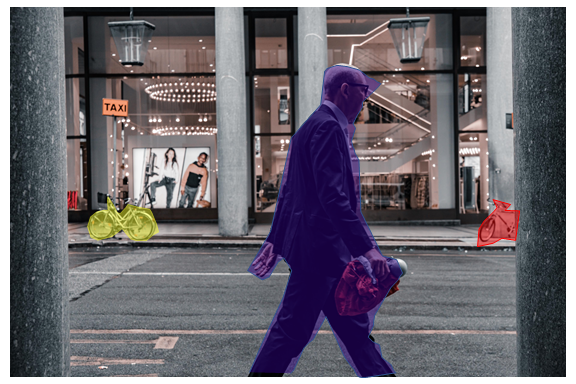

Come si può immaginare, la segmentazione semantica condivide diversi aspetti con la object detection, a partire dal fatto che in una singola scena possono essere presenti più oggetti di interesse e che gli oggetti possono appartenere a classi diverse. 






# Dataset per la segmentazione semantica

Come dataset di esempio continueremo ad usare [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), questa volta nella sua variante segmentazione. Anche in questo caso abbiamo necessità di scrivere una funzione di aggregazione per poter importare correttamente le label. Per la segmentazione semantica, la label è costituita da un'immagine in scala di grigi (ossia un singolo channel) dove però ogni colore codifica una precisa classe.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.transforms.functional as FT
import PIL

mappaColoriVOC = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

classiVOC = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

#Numero di classi per il dataset VOC
numClassi = len(classiVOC)

#Funzione per importare correttamente le labels di segmentazione
def aggregaCampioni(batch):
  #Liste usate per raggruppare in modo omogeneo i dati  
  immagini = list()
  maschere = list()

  #Estrazione delle immagini e delle maschere da ogni campione b presente in un batch
  for b in batch:
    img = b[0]
    maschera = b[1]

    #Conversione della maschera
    height, width = np.shape(maschera)
    segmentation_mask = np.zeros((height, width, numClassi), dtype=np.float32)
    for label_index, label in enumerate(mappaColoriVOC):
        segmentation_mask[:, :, label_index] = np.all(np.array(maschera.convert('RGB')) == label, axis=-1).astype(float)

    #Resize dell'immagine e dei box
    img = FT.resize(img, (224, 224))
    segmentation_mask = FT.resize(transforms.ToTensor()(segmentation_mask), (224, 224), PIL.Image.NEAREST)

    #Aggiunta
    immagini.append(img)
    maschere.append(segmentation_mask)

  #Impilamento di tutte le immagini e maschere
  immagini = torch.stack(immagini, dim=0)
  maschere = torch.stack(maschere, dim=0)

  return immagini, maschere

La funzione di aggregazione realizzata ricorda molto da vicino quella progettata per il caso della object detection. La differenza sostanziale riguarda la gestione delle classi. Si tratta infatti di mappe di segmentazione, ossia ogni oggetto (nelle venti classi previste da VOC più una per lo sfondo) è codificato da un particolare colore. 

Le mappe di segmentazione fornite da `torchvision` sono "palettizzate", ossia il valore numerico contenuto nella matrice costituente l'immagine è in realtà un indice ad una palette di colori. Per esplicitare le classi, abbiamo quindi creato una nuova maschera di segmentazione in codifica one-hot, dove ogni canale rappresenta una classe (e un pixel diverso da 0 in un determinato canale, indica che quel pixel appartiene alla classe di indice omologo).

Possiamo quindi passare alla preparazione dei dataset e alla visualizzazione di un campione, a scopo d'esempio.

In [ ]:
##########################################################
#                                                        #
# L'esecuzione della cella può richedere diversi minuti  #
#                                                        #
##########################################################

import torch
import numpy as np
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
import patoolib
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)

#Download da torchvision e preparazione dei dataset
trasf = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Estrazione dei dataset dalla cartella di lavoro locale
os.mkdir('vocSEG_Train')
patoolib.extract_archive("VOCtrainval_06-Nov-2007.tar", outdir=os.path.join(os.getcwd(), 'vocSEG_Train'))
os.mkdir('vocSEG_Test')
patoolib.extract_archive("VOCtest_06-Nov-2007.tar", outdir=os.path.join(os.getcwd(), 'vocSEG_Test'))

trainingSet = datasets.VOCSegmentation('vocSEG_Train', year='2007', image_set='train', download=False, transform=trasf)
testSet = datasets.VOCSegmentation('vocSEG_Test', year='2007', image_set='test', download=False, transform=trasf)

#Parametri dataloader
dimBatchTrain = 32
dimBatchVal = 32
dimBatchTest = 1

#Creazione dei dataloader
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.10)
trainingLoader = torch.utils.data.DataLoader(trainingSet, batch_size=dimBatchTrain, shuffle=True, collate_fn=aggregaCampioni)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=False, collate_fn=aggregaCampioni)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=False, collate_fn=aggregaCampioni)

#Estrazione di un campione per visualizzazione
campione = trainingSet.__getitem__(10)
img = campione[0]
maschera = campione[1]

#Conversione della maschera da "palettizzata" a RGB
maschera = maschera.convert('RGB')

#Visualizzazione
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(img,(1,2,0)))    #Si noti che stiamo visualizzando un'immagine normalizzata, quindi ci saranno degli artefatti
plt.title('Immagine')
plt.subplot(1, 2, 2)
plt.imshow(maschera)
plt.title('Maschera di segmentazione')

# CNN per la segmentazione semantica

Anche in questo caso, la segmentazione semantica era già effettuata prima dell'esplosione delle CNN. Tuttavia, le CNN hanno permesso di semplificare alcuni aspetti, permettendo al contempo di migliorare le performance complessive. I primi approcci basati su CNN prevedevano l'uso di una CNN pre-addestrata, alla quale sostituire il layer di classificazione con un nuovo layer progettato per effettuare una predizione della classe per ogni pixel. Successivamente sono state realizzate nuove architetture appositamente progettate per lo scopo. In questa lezione utilizzeremo una rete nota come `ResNetUNet`, un'architettura ibrida tra una ResNet ed una UNet. Partiamo da quest'ultima, usando (a titolo di esempio) una UNet a cinque livelli, che presenta un ingresso di 64x64 pixels.

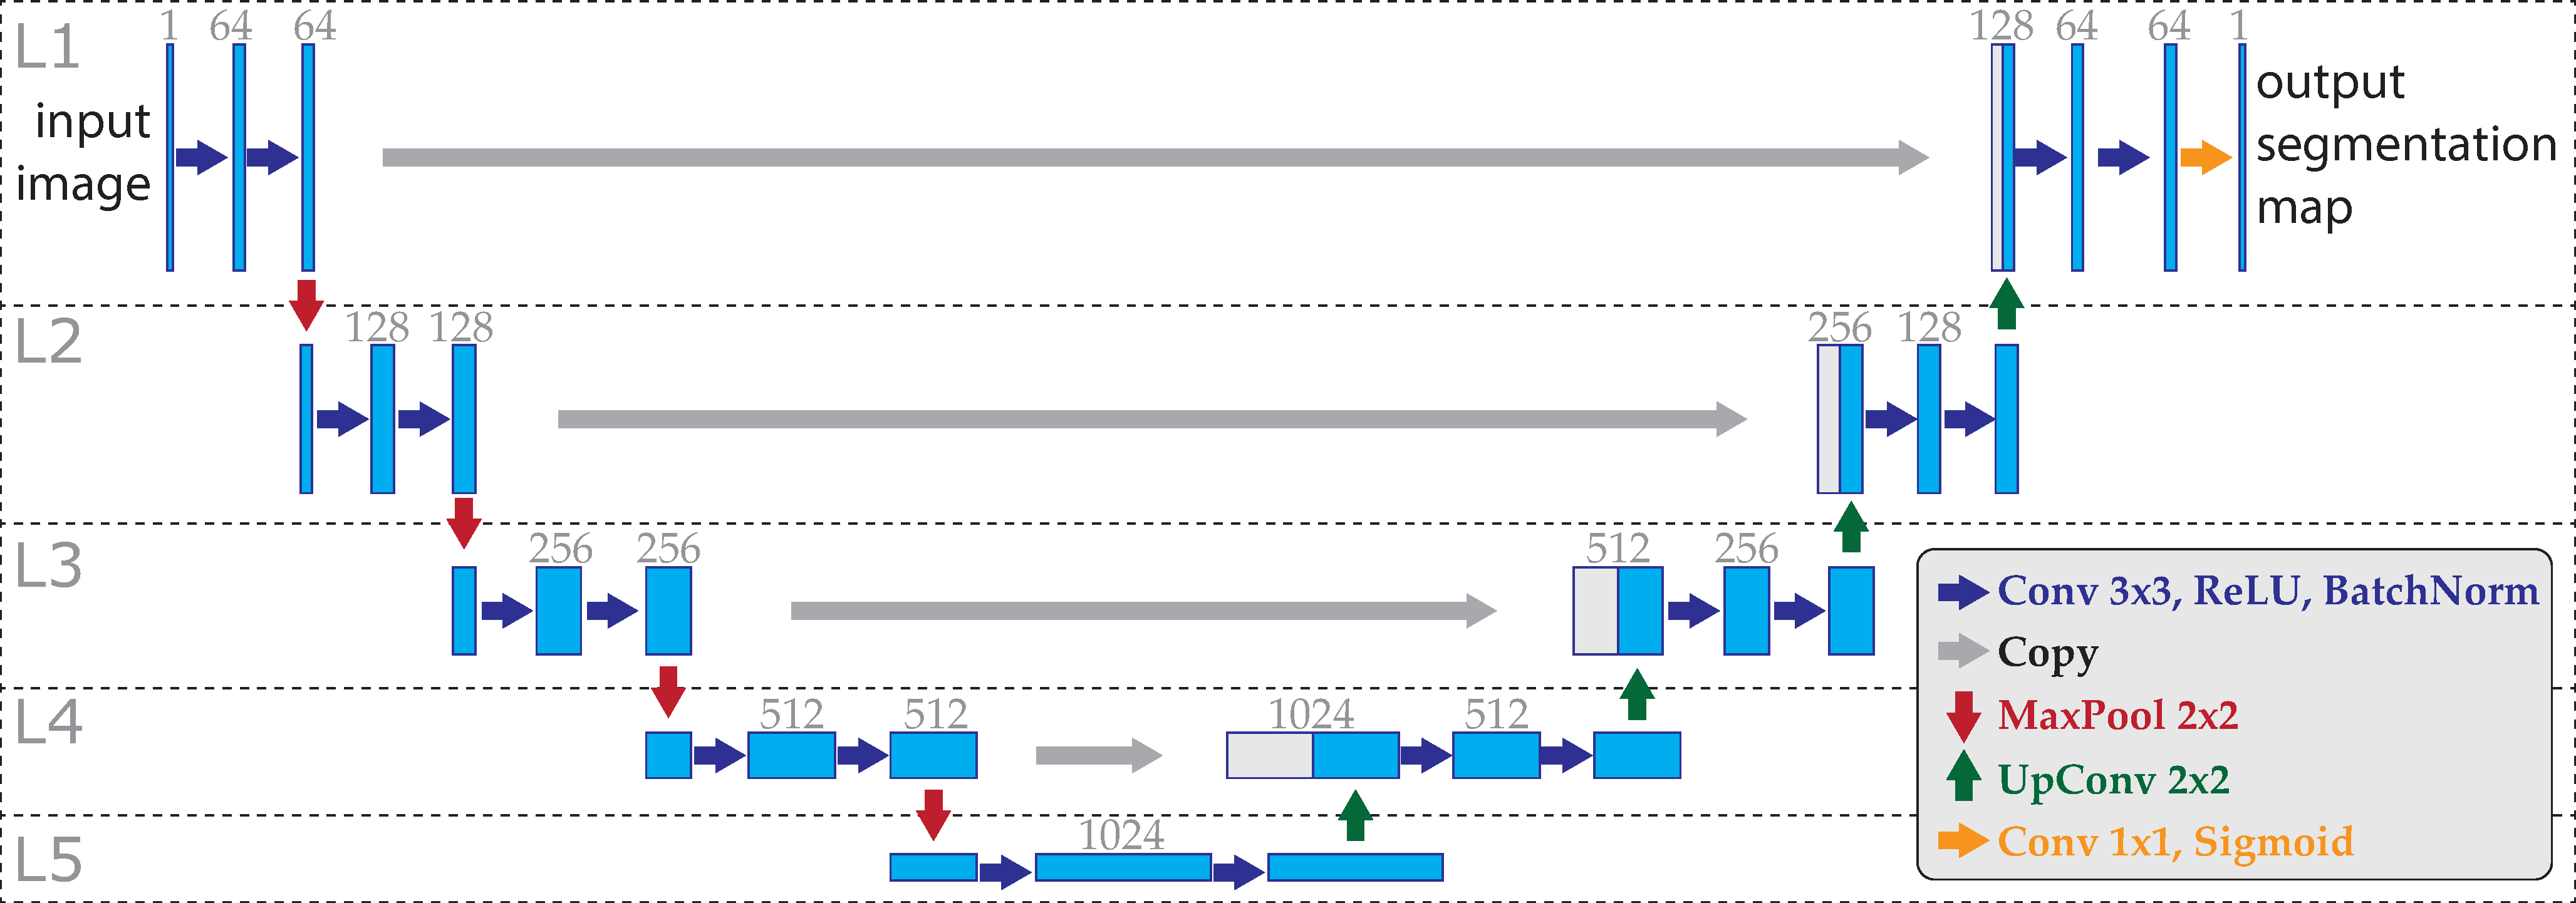

Come si vede dalla figura, la UNet prende il nome dalla sua struttura a forma di U. Si tratta di una rete fully convolutional appartenente alla famiglia degli autoencoder. Infatti, il ramo discendente (noto come encoder) compatta l'immagine in ingresso in un set di feature che saranno poi utilizzate dal ramo ascendente (noto come decoder) per generare la mappa di segmentazione. 

La ResNetUNet non è altro che una variante ibrida, in cui l'encoder è sostituito con una (buona parte dei layers di una) ResNet. Il vantaggio di tale operazione è che è possibile utilizzare una ResNet pre-addestrata, riducendo quindi il tempo necessario per l'addestramento.

In [ ]:
import torch.nn as nn
from torchvision import models

#Layer di comodo, definito per snellire la definizione della rete
def convrelu(inputData, outputData, kernel, padding):
    return nn.Sequential(nn.Conv2d(inputData, outputData, kernel, padding=padding),
                         nn.ReLU(inplace=True))

#Definizione del modello
class ResNetUNet(nn.Module):
    def __init__(self, numClassi):
        super().__init__()

        self.modelloBase = models.resnet18(pretrained=True)
        self.layersBase = list(self.modelloBase.children())

        #Ramo discendente
        self.layer0 = nn.Sequential(*self.layersBase[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.layersBase[3:5]) 
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.layersBase[5] 
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.layersBase[6]  
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.layersBase[7]  
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        #Funzione di "accrescimento" utilizzata
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        #Ramo ascendente
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.convOriginaleDim0 = convrelu(3, 64, 3, 1)
        self.convOriginaleDim1 = convrelu(64, 64, 3, 1)
        self.convOriginaleDim2 = convrelu(64 + 128, 64, 3, 1)

        #Layer di predizione delle maschere di segmentazione
        self.conv_finale = nn.Conv2d(64, numClassi, 1)

    def forward(self, input):
        x_originale = self.convOriginaleDim0(input)
        x_originale = self.convOriginaleDim1(x_originale)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_originale], dim=1)
        x = self.convOriginaleDim2(x)

        out = self.conv_finale(x)

        return out

In [ ]:
#Codice di supporto per il caricamento in locale del modello pre-addestrato

!mkdir /home/jovyan/.cache/torch/ /home/jovyan/.cache/torch/hub/ /home/jovyan/.cache/torch/hub/checkpoints
!cp resnet18-5c106cde.pth /home/jovyan/.cache/torch/hub/checkpoints

In [ ]:
#Istanziazione
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modello = ResNetUNet(numClassi)
modello = modello.to(device)

# Funzione di loss per la segmentazione semantica

La segmentazione semantica può essere vista come l'estremizzazione della classificazione, in cui una classe è assegnata ad ogni pixel (invece che all'intera immagine). La diretta consequenza è la possibilità di utilizzare le classiche funzioni di loss utilizzate nella classificazione (come la *CrossEntropy*). Tuttavia, usare solo questo tipo di loss non permette di tenere in conto del fatto che gli oggetti sono "continui", e quindi la rete potrebbe predire un'auto delineandone bene i contorni, ma lasciando pixel associati ad altre classi al suo interno. 

Per ovviare a questo problema, in genere le loss usate nella segmentazione semantica prevedono anche una componente che tenga in conto della regione di segmentazione, e della sua sovrapposizione a quella vera (in maniera simile a quanto fatto dall'indice di Jaccard). Tra tutte, una delle metriche più utilizzate è il coefficiente di Dice, definito come $\frac{2*|A \cap B|}{|A| \cup |B|}$, dove con $|X|$ indichiamo la cardinalità della generica maschera $X$. La loss complessiva è quindi formata dalla combinazione lineare (pesate a somma 1) di due componenti. 

In [ ]:
from collections import defaultdict
import torch.nn.functional as funct

#Dice Similarity Coefficient (DSC)
def DSC(predizione, gt, smooth = 1.):
    predizione = predizione.contiguous()
    gt = gt.contiguous()    
    intersezione = (predizione * gt).sum(dim=2).sum(dim=2)
    DSC = (2. * intersezione + smooth) / (predizione.sum(dim=2).sum(dim=2) + gt.sum(dim=2).sum(dim=2) + smooth)
    return DSC

#Loss di Dice (Dice Similarity Coefficient)
def DSC_loss(predizione, gt):
    loss = 1 - DSC(predizione, gt)
    return loss.mean()

def lossTotale(predizione, gt, peso):
    bce = funct.binary_cross_entropy_with_logits(predizione, gt)
    predizione = funct.sigmoid(predizione)
    dice = DSC_loss(predizione, gt)
    loss = bce * peso + dice * (1 - peso)

    return loss

Si noti infine che l'indice di Dice rappresenta un ottimo indicatore delle performance di un algoritmo di segmentazione semantica. Per questioni didattiche è di interesse valutare le performance su tutti i dataset. Progettiamo quindi una funzione che valuti le performance in termini di indice di Dice.

In [ ]:
def valutaPerformanceDice(datasetLoader, modello):
  #Preallocazione della variabile di accumulo
  dice = 0
  
  #Modalità inferenza
  modello.eval()
  with torch.no_grad():
    for immagini, maschere in trainingLoader:
      #Gestione GPU
      immagini = immagini.to(device)
      maschere = maschere.to(device)

      #Predizione
      mascherePredette = modello(immagini)

      #Dice
      diceBatch = DSC(mascherePredette, maschere)
      dice += diceBatch.mean()

  return dice

# Addestramento

Possiamo quindi procedere con l'addestramento, senza introdurre nessuna significativa variazione al codice utilizzato nelle lezioni precedenti.

L'esecuzione della fase di addestramento del codice seguente potrebbe richiedere **una quantità di tempo considerevole**. Per questo motivo, è presente una cella alternativa in grado di caricare i parametri e le variabili risultanti da un'esecuzione della cella precedente.

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VUOLE EFFETTUARE L'ADDESTRAMENTO.  #
#               Eseguire la cella seguente se si vogliono caricare le variabili     #
#               necessarie già pronte per l'uso.                                    #
#                                                                                   #
##################################################################################### 

import torch.optim as optim
from torch.optim import lr_scheduler

epoche = 10
lr = 1e-3
pesoLoss = 0.5 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, modello.parameters()), lr=lr)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

#Ciclo di addestramento
for e in range(epoche):
    modello.train()

    #Loss dell'epoca corrente
    lossTrainEpoca = 0

    #Ciclo sui batch
    for immagini, maschere in trainingLoader:  
        #Gestione GPU
        immagini = immagini.to(device)
        maschere = maschere.to(device)

        #Passo di forward
        mascherePredette = modello(immagini)

        #Valutazione della loss
        lossTrain = lossTotale(mascherePredette, maschere, pesoLoss)
        lossTrainEpoca += lossTrain.item()*immagini.size(0) 

        #Passo di backward
        optimizer.zero_grad()
        lossTrain.backward()

        #Aggiornamento pesi
        optimizer.step()

    #Valutazione performance sul Training Set
    diceTrain = valutaPerformanceDice(trainingLoader, modello)

    #Valutazione performance sul Validation Set
    diceVal = valutaPerformanceDice(validationLoader, modello)

    #Visualizzazione
    print("Epoca {}:".format(e))
    print("Loss sul Training Set: {} - DSC sul Training Set: {} - DSC sul Validation Set: {}".format(lossTrainEpoca, diceTrain, diceVal))
    print("--------------------------------------------------------------------------------------------------")

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VOGLIONO CARICARE I DATI PRONTI.   #
#               Non è necessario eseguire questa cella se si è eseguita quella      #
#               precedente, dove è stato effettuato l'addestramento.                #
#                                                                                   #
##################################################################################### 

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Inizializzazione 
modello = ResNetUNet(numClassi)

#Caricamento da disco
modello.load_state_dict(torch.load('preElaborato.pth',map_location=torch.device('cpu')))
modello = modello.to(device)

Avendo ora un modello addestrato, possiamo valutare le performance sul test set, visualizzando anche le maschere predette per un generico campione.

In [ ]:
##########################################################
#                                                        #
# L'esecuzione della cella può richedere diversi minuti  #
#                                                        #
##########################################################

#Valutazione performance sul Test Set
diceTest = valutaPerformanceDice(testLoader, modello)
print("DSC sul Test Set: {}".format(diceTest))

#Visualizzazione delle maschere per un campionne
immagini, maschera = next(iter(testLoader))
immagini = immagini.to(device)
maschera = maschera.to(device)

#Predizione
modello.eval()
mascheraPredetta = modello(immagini)
mascheraPredetta = funct.sigmoid(mascheraPredetta)
mascheraPredetta = mascheraPredetta.data.cpu().numpy()
mascheraPredetta = mascheraPredetta[0].squeeze()

#Conversione da one-hot a RGB per la maschera vera
mascheraVera = maschera[0].cpu().squeeze()
mascheraVeraRGB = np.zeros((224, 224, 3), dtype=np.uint8)
for label_index, label in enumerate(mappaColoriVOC):
  mascheraVeraRGB[mascheraVera[label_index] >= 0.5,:] = label

#Conversione da one-hot a RGB per la maschera predetta
mascheraPredettaRGB = np.zeros((224, 224, 3), dtype=np.uint8)
for label_index, label in enumerate(mappaColoriVOC):
  mascheraPredettaRGB[mascheraPredetta[label_index] >= 0.3,:] = label


In [ ]:
#Visualizzazione
img = immagini[0].cpu().squeeze()
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(img,(1,2,0)))    #Si noti che stiamo visualizzando un'immagine normalizzata, quindi ci saranno degli artefatti
plt.title('Immagine')
plt.subplot(1, 3, 2)
plt.imshow(mascheraVeraRGB)
plt.title('Maschera di segmentazione vera')
plt.subplot(1, 3, 3)
plt.imshow(mascheraPredettaRGB)
plt.title('Maschera di segmentazione predetta')

Al di la delle performance di segmentazione (dovute alla scarsa quantità di dati di addestramento disponibili e al ridotto numero di epoche usato), è interessante osservare la funzione utilizzata per convertire le maschere da codifiche one-hot a RGB. Nel caso della maschera vera, abbiamo usato 0.5 come valore di soglia. Tuttavia, essendoci al suo interno solo valori 0 o 1, un qualsiasi valore di soglia diverso da zero è adatto allo scopo. 

Discorso diverso vale per la maschera predetta. La motivazione è nel fatto che la rete produce in output valori continui e non valori discreti 0 e 1. Dunque, l'uso di un valore di soglia per binarizzare la predizione è cruciale. Sebbene il valore 0.5 possa essere il più intuitivo, nella pratica non è detto che sia il più efficace (nell'esempio abbiamo usato 0.3).